In [1]:
import os

import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

from devinterp.slt.rlct_tune_utils import *
from devinterp.slt.learning_coeff import plot_learning_coeff_trace
from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp import data_root

from joblib import Parallel, delayed



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]

In [2]:
def load_model(num_layers, device=device):
    model_name = f"resnet{num_layers}"
    model = getattr(torchvision.models, model_name)(pretrained=True).to(device)
    checkpoint_folder = f"../checkpoints/resnet-finetuned-cifar/"
    checkpoint_full_path = checkpoint_folder + f"{model_name}.pt"
    if os.path.exists(checkpoint_full_path):
        print("Loading from checkpoint")
        model.load_state_dict(torch.load(checkpoint_full_path))
    else:
        raise Exception("No checkpoint found")
    return model

In [7]:
# Transform to imagenet format
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.244, 0.225]),
    ]
)

trainset = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root="../data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12185268.74it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [14]:
for i in trainloader:
    model = load_model(18)
    model.eval()
    with torch.no_grad():
        print(model(i[0].to(device)))
    break
    

/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading from checkpoint
tensor([[ 7.9531,  7.8488, 17.9588,  ..., -0.7141, -0.6866,  0.9864],
        [14.9787,  9.8696, 14.0084,  ..., -0.1113,  0.7950, -0.9750],
        [14.4827, 11.9165, 10.5515,  ...,  0.3939,  0.6887,  0.5418],
        ...,
        [ 9.2378,  9.8167, 13.9119,  ..., -0.1608,  0.1950, -0.7659],
        [23.7161, 12.6826, 15.0192,  ...,  0.6740,  2.8368, -0.5683],
        [13.2881,  8.2840, 17.0781,  ..., -0.6174,  2.0513,  1.4085]])


In [32]:
# good: SGNHT, lr=1e-5, diffusion_factor=0.01, num_draws=100
hyperparams = {
    "lr_list": [1e-5],
    "restrict_to_orth_grad_list": [False],
    "optimizer_list": [SGLD],
    "num_samples": [len(trainset)],

    # SGNHT
    "diffusion_factor_list": [0.01],

    # SGLD
    "noise_level_list": [0.5],
    "elasticity_list": [100.0],
    "temperature_list": ['adaptive'],

    # chain config
    "num_draws": [100],
    "num_chains": [3],
}
model = load_model(18)
# run parallel jobs
args_list = make_args_list(**hyperparams)
# print(args_list)
rlct_estimate_summary_list = Parallel(n_jobs=8, verbose=10)(
    delayed(get_summary_for_hyperparams)(model, args, loader=trainloader) 
    for args in args_list)
# rlct_estimate_summary_list = [get_summary_for_hyperparams(copy.deepcopy(model), args) for args in args_list]

/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading from checkpoint


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 10.1min


In [25]:
len(trainloader.dataset)

50000

lr: 1e-05, SGNHT, diffusion_factor: 0.01, num_draws: 100, restrict_to_orth_grad: False, num_samples: 50000, num_chains: 3, 


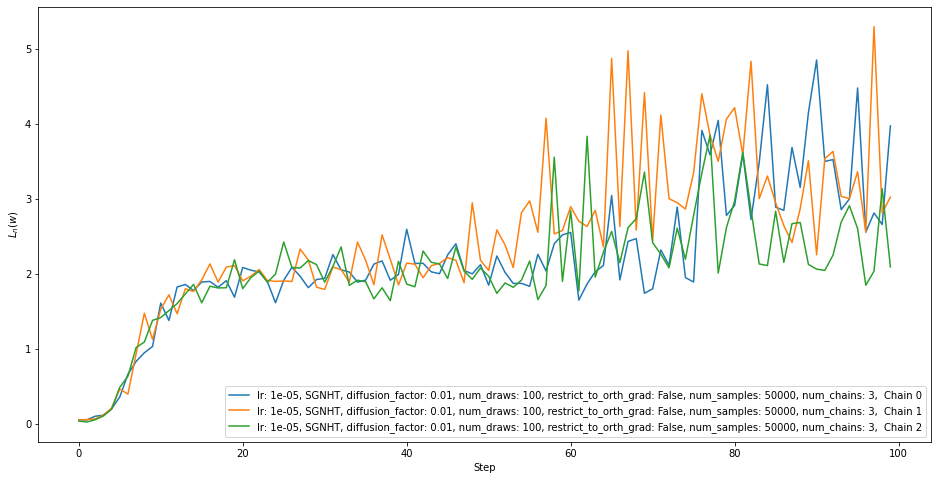

In [33]:
# plot summary traces
args_list = make_args_list(**hyperparams)
for rlct_estimate_summary, args in zip(rlct_estimate_summary_list, args_list):
    # make label out of args
    label = ""
    for key, value in args.items():
        if key == "optimizer":
            label += f"{value.__name__}, "
        else:
            label += f"{key}: {value}, "
    print(label)
    trace = rlct_estimate_summary['trace']
    for chain, df in trace.groupby("chain"):
        plt.plot(df["step"], df["loss"], label= f"{label} Chain {chain}")
plt.xlabel("Step")
plt.ylabel(r"$L_n(w)$")
plt.legend()
plt.gcf().set_size_inches(16, 8)

In [35]:
[(rlct_estimate_summary_list[i]['std'], rlct_estimate_summary_list[i]['mean'], args_list[i]) for i in range(len(rlct_estimate_summary_list))]

[(940.2910766601562,
  10110.2236328125,
  {'lr': 1e-05,
   'optimizer': devinterp.optim.sgnht.SGNHT,
   'diffusion_factor': 0.01,
   'num_draws': 100,
   'restrict_to_orth_grad': False,
   'num_samples': 50000,
   'num_chains': 3})]

In [29]:
[(rlct_estimate_summary_list[i]['std'], args_list[i]) for i in range(len(rlct_estimate_summary_list))]

[(13.736393928527832,
  {'lr': 1e-05,
   'optimizer': devinterp.optim.sgld.SGLD,
   'noise_level': 0.5,
   'elasticity': 100.0,
   'temperature': 'adaptive',
   'num_draws': 100,
   'num_samples': 50000,
   'restrict_to_orth_grad': False,
   'num_chains': 3}),
 (36.16845703125,
  {'lr': 1e-05,
   'optimizer': devinterp.optim.sgld.SGLD,
   'noise_level': 1.0,
   'elasticity': 100.0,
   'temperature': 'adaptive',
   'num_draws': 100,
   'num_samples': 50000,
   'restrict_to_orth_grad': False,
   'num_chains': 3}),
 (4.668585777282715,
  {'lr': 1e-05,
   'optimizer': devinterp.optim.sgld.SGLD,
   'noise_level': 2.0,
   'elasticity': 100.0,
   'temperature': 'adaptive',
   'num_draws': 100,
   'num_samples': 50000,
   'restrict_to_orth_grad': False,
   'num_chains': 3})]